# Eldery Monitoring Project

This project uses sensor data from a home-based monitoring study to explore non-invasive methods for tracking the daily activity of an elderly individual living alone. The dataset includes gas, temperature, and infrared motion sensor readings collected from November 2019 to February 2020.

The goal is to predict which room the person was in using gas sensor data and to compare the performance of various machine learning models for this multi-class classification task.

study reference: https://www.sciencedirect.com/science/article/pii/S0925400523007517

dataset refernce: https://archive.ics.uci.edu/dataset/799/single+elder+home+monitoring+gas+and+position


## Step 1: Preprocessing and Merging

The dataset came with three files: database_gas.csv, database_pos.csv, and data_ref_until_2020-02-13.csv. The first file contained gas sensor data with timestamps, the second recorded the occupant’s location within the home, and the third consisted of 19 days of reference data when no one was present in the house. My first task was to merge database_gas.csv and database_pos.csv into a single file.

However, the two files were recorded at slightly different intervals, so I performed the merge based on the nearest timestamp. Since the differences were only a few seconds at most, I considered them negligible—but I still recognize this as a potential limitation in the results. Additionally, the two datasets used different time zones, which required correction before merging. After handling these issues, I successfully combined the datasets and saved the result as merged_data.csv.

In [1]:
import pandas as pd

# Load the gas/temperature/humidity data
gas_df = pd.read_csv("database_gas.csv")

# Load the position (room) data
pos_df = pd.read_csv("database_pos.csv")

# Ensure datetime columns are parsed correctly
gas_df['datetime'] = pd.to_datetime(gas_df['timestamp'], utc=True)
pos_df['datetime'] = pd.to_datetime(pos_df['datetime'], utc=True)

# Convert gas_df from UTC+01:00 to UTC
gas_df['datetime'] = gas_df['datetime'].dt.tz_convert('UTC')

# Sort both DataFrames by datetime
gas_df = gas_df.sort_values('datetime')
pos_df = pos_df.sort_values('datetime')

# Do a nearest timestamp merge
# **might be a limitation**
merged_df = pd.merge_asof(
    gas_df,
    pos_df,
    on='datetime',
    direction='nearest'  # or 'nearest' if you prefer that
)

In [2]:
merged_df.head()
merged_df.info()
merged_df.to_csv('merged_data.csv', index=False)
print("saved")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416153 entries, 0 to 416152
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   timestamp      416153 non-null  object             
 1   temperature    416153 non-null  float64            
 2   humidity       416153 non-null  float64            
 3   CO2CosIRValue  416153 non-null  float64            
 4   CO2MG811Value  416153 non-null  float64            
 5   MOX1           416153 non-null  float64            
 6   MOX2           416153 non-null  float64            
 7   MOX3           416153 non-null  float64            
 8   MOX4           416153 non-null  float64            
 9   COValue        416153 non-null  float64            
 10  datetime       416153 non-null  datetime64[ns, UTC]
 11  Living room    119043 non-null  float64            
 12  Bedroom        112610 non-null  float64            
 13  Bathroom       20691 non-null

## Step 2: Exploring Data

To better understand the dataset and uncover potential insights, I used data visualizations to explore patterns in sensor readings and movement data. This helped me form intuitions about the data distributions and relationships between sensor values and room labels before training any models. 

To prepare the data for classification, I created a new column called active_room to indicate which room the person was in at each timestamp. Since the dataset had separate columns for each room’s activity, I assumed that only one room could be active at a time. I used the idxmax function to determine which room had the highest value in each row (after filling missing values with zero to reduce warnings), effectively labeling the person’s location. This allowed me to frame the problem as a multi-class classification task, where the goal is to predict a single room label based on sensor inputs.

After closely reading the feasibility study, I gathered that CO2 levels, measured by CO2MG811Value and CO2CosIRValue, were most relevant to active room prediction, while the other variables were helpful in other ways, such as detecting volatiles and detecting cross-sensitivity.

In [3]:
# Determine the active room (assuming only one room is active per row)
room_cols = ['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']

# Fill NaNs with 0 for room columns so idxmax doesn't raise issues
merged_df['active_room'] = merged_df[room_cols].fillna(0).idxmax(axis=1)

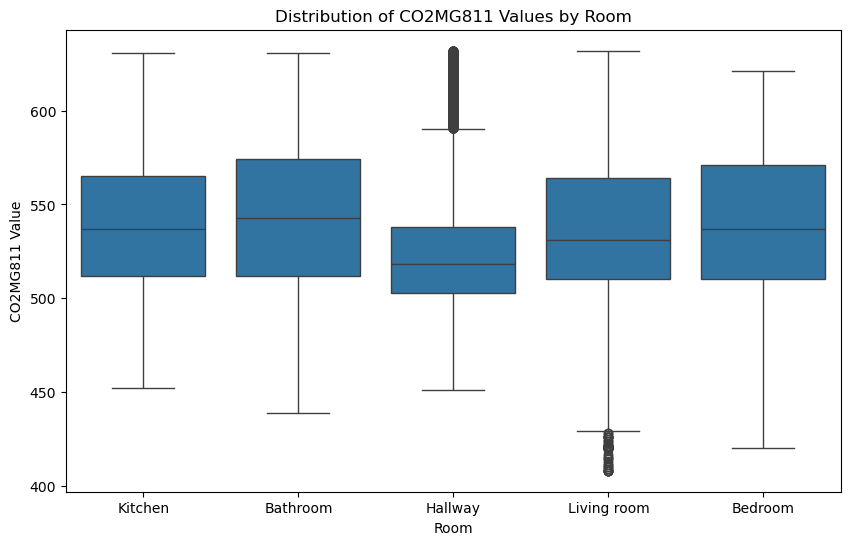

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x='active_room', y='CO2MG811Value', data=merged_df)
plt.title('Distribution of CO2MG811 Values by Room')
plt.ylabel('CO2MG811 Value')
plt.xlabel('Room')
plt.show()


This boxplot displays the distribution of CO2MG811 values (a gas sensor reading) across different rooms in the home. By plotting the CO2 values for each room, I can easily identify the central tendency (median) and spread (interquartile range) of the sensor readings. The plot also highlights potential outliers, which could indicate unusual sensor data or human activity. This visualization is crucial for understanding how gas sensor readings vary between rooms, helping me to link these readings to the specific room where the elderly person is likely to be active. By comparing rooms, I can assess if there’s any significant difference in sensor data that could inform model predictions.

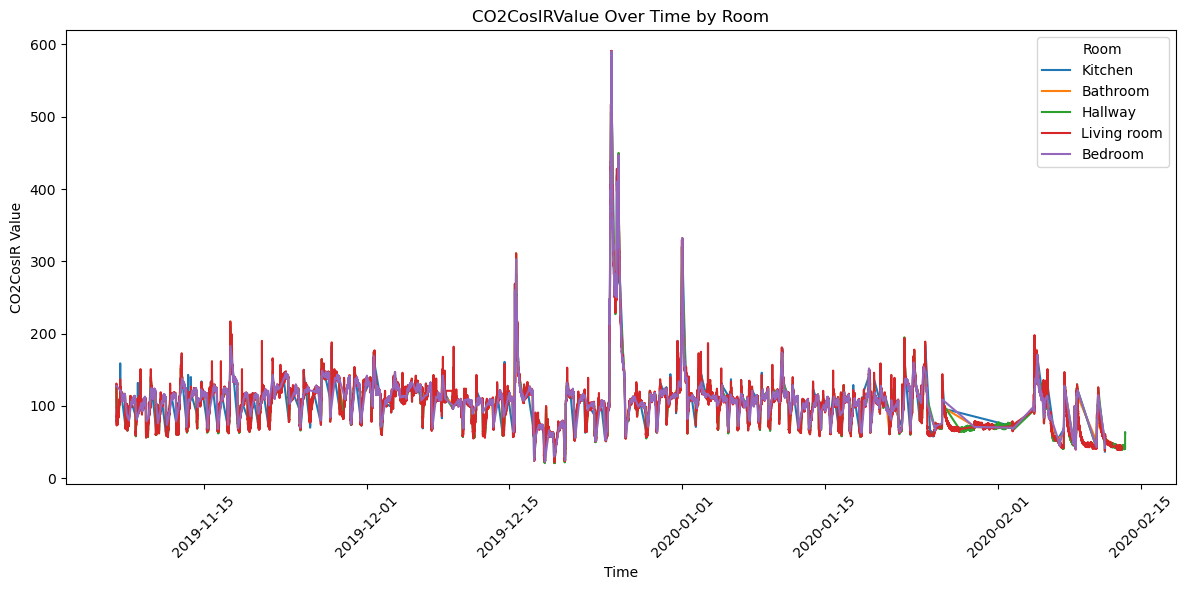

In [5]:
plt.figure(figsize=(12,6))
sns.lineplot(x='datetime', y='CO2CosIRValue', hue='active_room', data=merged_df)
plt.title('CO2CosIRValue Over Time by Room')
plt.xlabel('Time')
plt.ylabel('CO2CosIR Value')
plt.xticks(rotation=45)
plt.legend(title='Room')
plt.tight_layout()
plt.show()

This line plot shows the CO2CosIR sensor values over time, grouped by the active room. The x-axis represents time, while the y-axis represents the CO2CosIR sensor readings. Each room is represented by a different color, allowing us to track how the CO2 levels change in each room throughout the monitoring period. This visualization is useful for understanding the trends in gas sensor data over time, as it reveals patterns that could indicate when the elderly person is likely to be in specific rooms. By observing the CO2 fluctuations, I can gain insights into activity patterns and determine the relationship between the sensor data and room occupancy.

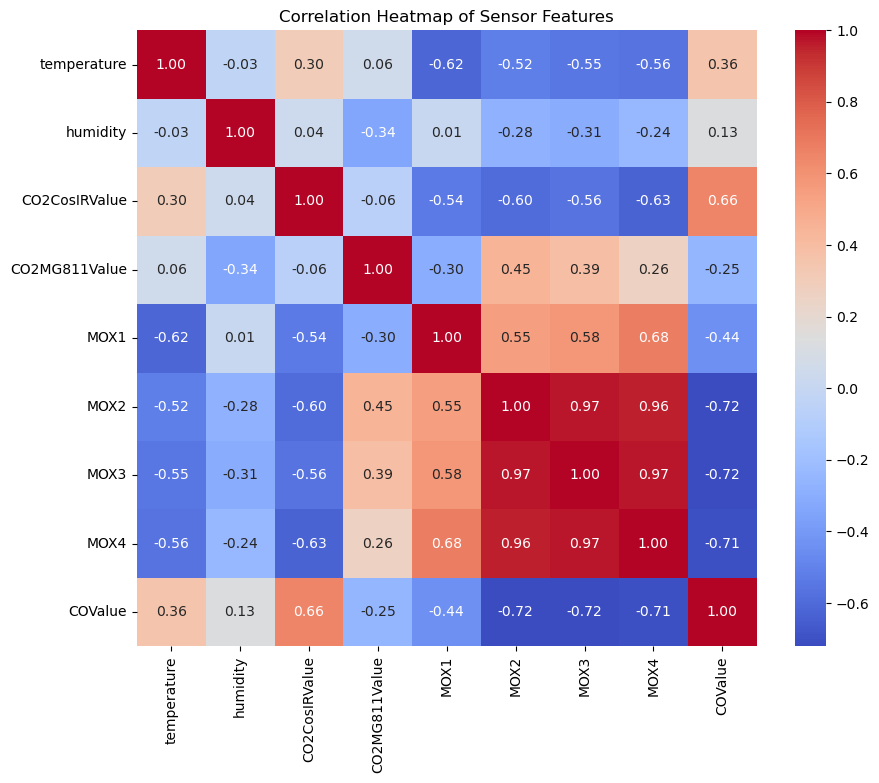

In [6]:
plt.figure(figsize=(10, 8))
sensor_cols = ['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']
corr = merged_df[sensor_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Sensor Features')
plt.show()

This heatmap visualizes the correlation between various sensor features in the dataset, including temperature, humidity, CO2CosIRValue, CO2MG811Value, and multiple MOX sensor values. The color scale indicates the strength and direction of the correlations, where darker colors represent stronger correlations. This plot is important because it helps identify relationships between the sensors that may capture similar or complementary information about the environment. Understanding these correlations can aid in feature selection for model training, highlighting which sensor readings might be most useful for predicting room occupancy or activity levels. Additionally, it can provide insight into how sensor data may overlap or influence one another, allowing for more informed model-building decisions.

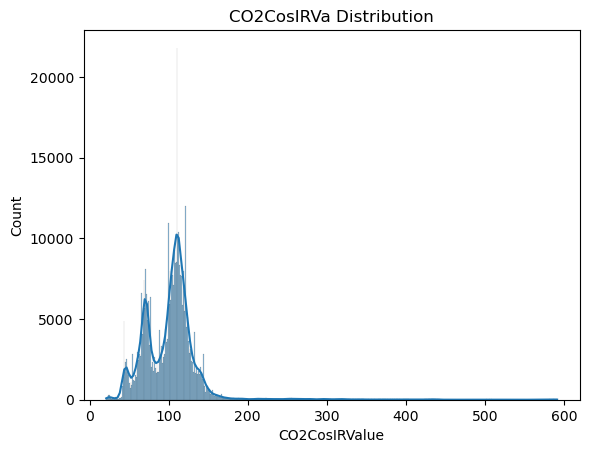

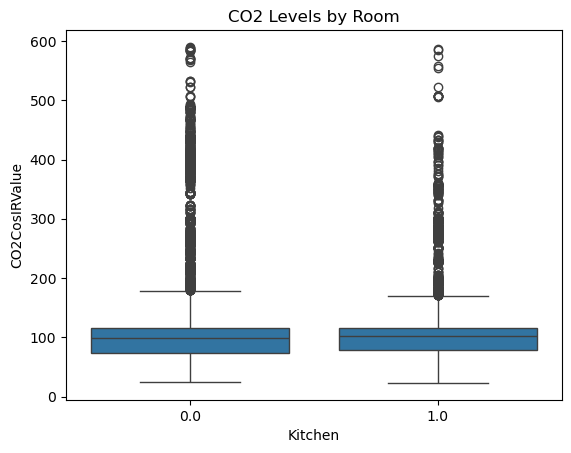

In [7]:
# Plot distributions
sns.histplot(data=merged_df, x='CO2CosIRValue', kde=True)
plt.title('CO2CosIRVa Distribution')
plt.show()

# Boxplot by room
sns.boxplot(data=merged_df, x='Kitchen', y='CO2CosIRValue')
plt.title('CO2 Levels by Room')
plt.show()

The histogram and KDE plot shows the distribution of the CO2CosIRValue across the entire dataset. The plot helps identify the central tendency (mean/median) and the spread of the data, giving insights into how CO2 levels are generally distributed. It also allows us to detect any skewness or unusual patterns that might require further exploration or transformation.

The boxplot shows the distribution of CO2CosIRValue by room, highlighting variations in CO2 levels across different areas of the home. The boxplot visualizes the median, quartiles, and any potential outliers for each room. This is useful for understanding which rooms have higher or lower CO2 levels and identifying rooms that might need special attention due to unusual CO2 variations.

## Step 3: Baseline Model - Random Forest Classifier

For the baseline model, I used a Random Forest classifier to predict the active room based on sensor data. Random Forest is a robust ensemble learning method that builds multiple decision trees and combines their outputs to improve accuracy and reduce overfitting. This model was chosen as a starting point due to its effectiveness in handling complex, non-linear relationships in the data and its ability to manage missing values and outliers. It serves as a benchmark to compare against more advanced models later in the project.

### 3.1 Train/Test Split

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define feature columns (CO2 + other gas-related data)
feature_cols = ['CO2CosIRValue', 'CO2MG811Value', 'temperature', 'humidity',
                'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']

# Target is the active room
X = merged_df[feature_cols]
y = merged_df['active_room']  # should be one of the room names as a string

# Drop any rows with NaNs (or handle appropriately)
X = X.dropna()
y = y.loc[X.index]  # Keep alignedd\

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 3.2 Results

In [11]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Bathroom       0.70      0.60      0.65      1603
     Bedroom       0.96      0.96      0.96     11263
     Hallway       0.94      0.91      0.92      9157
     Kitchen       0.95      0.91      0.93      4760
 Living room       0.96      0.98      0.97     56448

    accuracy                           0.96     83231
   macro avg       0.90      0.87      0.89     83231
weighted avg       0.96      0.96      0.96     83231



The Random Forest model achieved a high accuracy of 96%, with strong performance in the Living Room, Bedroom, and Hallway, showing high precision, recall, and F1-scores. The Bathroom, however, had lower precision and recall, suggesting some difficulty in distinguishing activity there. This may be because of the shorter amount of time one spends in a bathroom relative to other rooms. Overall, the model performs well across most rooms, making it a solid baseline for further comparison with other models.

## Step 4: Model Tuning

Building on the solid performance of the baseline Random Forest model, I explored additional models to optimize the results further. I experimented with Logistic Regression, LightGBM, and XGBoost. These models offer different strengths, such as LightGBM and XGBoost's ability to handle large datasets and complex relationships, while Logistic Regression served as a simpler model for comparison. Through model tuning and evaluation, I aimed to determine which model would best capture the nuances of the data and improve overall predictive performance.

### 4.1 Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label encode
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with more iterations
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Results:\n")
print(classification_report(y_test, y_pred_logreg, target_names=le.classes_, zero_division=1))


Logistic Regression Results:

              precision    recall  f1-score   support

    Bathroom       1.00      0.00      0.00      1603
     Bedroom       0.38      0.07      0.11     11263
     Hallway       0.56      0.13      0.21      9157
     Kitchen       1.00      0.00      0.00      4760
 Living room       0.69      0.97      0.80     56448

    accuracy                           0.68     83231
   macro avg       0.73      0.23      0.23     83231
weighted avg       0.66      0.68      0.58     83231



The Logistic Regression model underperforms significantly, with an accuracy of only 68%. The recall for most rooms is extremely low, particularly for Bathroom and Kitchen, where it is 0%. This indicates that the model struggles to correctly identify the active room in these cases. Although the Living room has a high recall, the overall precision and F1-scores remain low due to the poor performance in other rooms. These results suggest that Logistic Regression is not a suitable model for this task, especially when compared to more complex models like Random Forest, XGBoost, and LightGBM.

### 4.2 LightGBM

In [13]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels if not done already
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgbm.predict(X_test)

# Evaluation
print("LightGBM Results:\n")
print(classification_report(y_test, y_pred_lgbm, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 332922, number of used features: 9
[LightGBM] [Info] Start training from score -3.917360
[LightGBM] [Info] Start training from score -1.999869
[LightGBM] [Info] Start training from score -2.201188
[LightGBM] [Info] Start training from score -2.818295
[LightGBM] [Info] Start training from score -0.393970
LightGBM Results:

              precision    recall  f1-score   support

    Bathroom       0.75      0.08      0.14      1603
     Bedroom       0.84      0.66      0.74     11263
     Hallway       0.95      0.70      0.81      9157
     Kitchen       0.94      0.30      0.45      4760
 Living room       0.83      0.97      0.89     56448

    accuracy                    

The LightGBM model achieves an accuracy of 84%, with relatively strong performance in identifying the Living room, Bedroom, and Hallway. However, its recall for the Bathroom and Kitchen rooms is quite low, particularly for Bathroom, where recall is only 0.08%. Despite the model's good performance on rooms with high support, the low recall for certain rooms indicates that there is still room for improvement, especially in better distinguishing between rooms with similar sensor readings. The macro average recall of 0.54 reflects the difficulty LightGBM has in identifying rooms with less distinct sensor data.

### 4.3 XGBoost

In [15]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels if not already done
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("XGBoost Results:\n")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:13:16] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:

              precision    recall  f1-score   support

    Bathroom       0.76      0.11      0.19      1603
     Bedroom       0.86      0.78      0.82     11263
     Hallway       0.95      0.76      0.85      9157
     Kitchen       0.94      0.43      0.59      4760
 Living room       0.86      0.97      0.91     56448

    accuracy                           0.87     83231
   macro avg       0.87      0.61      0.67     83231
weighted avg       0.88      0.87      0.86     83231



The XGBoost model yields an accuracy of 87%, performing well with high recall for the Living room (0.97) and Bedroom (0.78), but struggling with lower recall in the Bathroom (0.11) and Kitchen (0.43). While the overall accuracy and weighted averages are strong, the model's ability to identify certain rooms—particularly the Bathroom—is limited. The macro average recall of 0.61 further suggests that improvements could be made, particularly in rooms with less distinct sensor readings. However, the high weighted average indicates that the model performs better in larger rooms with more data, like the Living room.

## Step 8: Model Interpretation

The best model in our analysis was XGBoost, which delivered the most reliable results in terms of accuracy and performance across various metrics. To further interpret and understand how the model arrived at its predictions, I utilized SHAP (SHapley Additive exPlanations). SHAP values provide insights into how each feature contributes to individual predictions made by the model.

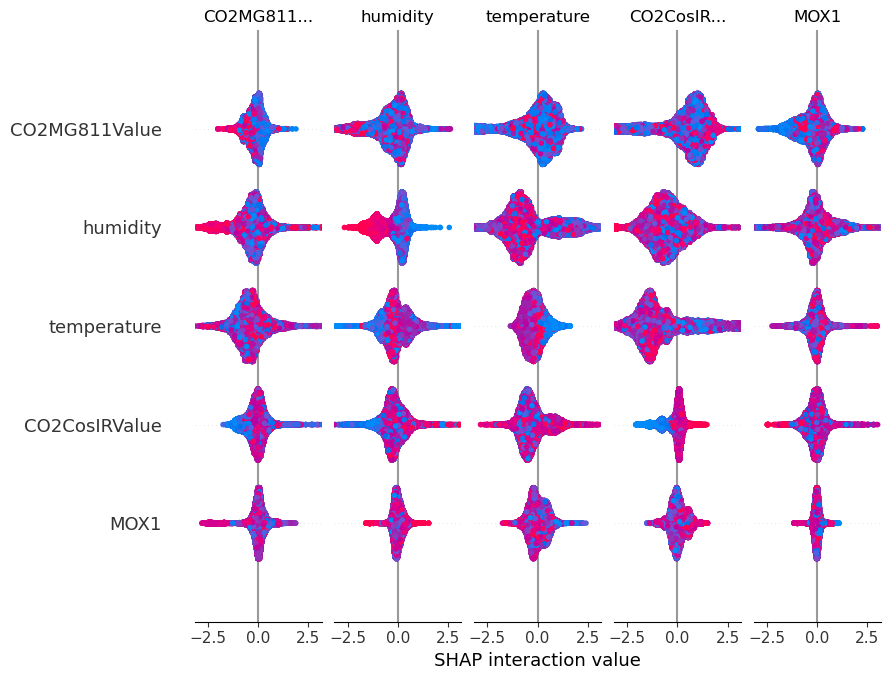

In [17]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb) 
shap_values = explainer.shap_values(X_test)  

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

By applying SHAP, I was able to analyze the importance of each feature and how they influenced the predicted outcome. The SHAP summary plot shows the distribution of these contributions, highlighting which features had the most significant impact on the model's predictions. This allowed me to gain a deeper understanding of the model’s decision-making process, ensuring that the results were not just accurate but also interpretable.